# the model suggested by the paper on the Tabula Sapiens Pseudobulks Dataset (normalized)

In [12]:
import wandb
wandb.login()

True

In [13]:
import torch
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.metrics import r2_score, mean_squared_error
import torch.nn as nn
import numpy as np
import pandas as pd
import scanpy as sc

from dataset import TS_Compressed_Dataset
import copy


In [14]:
config = dict(
    EPOCHS = 50,
    BATCH_SIZE = 1e3,
    LEARNING_RATE = 1e-3,
    NUM_LAYERS = 4,
)

In [15]:
#load the dataframe that contains one to one corresponding of gene id and gene index
gene_index = pd.read_csv("gene_index.csv")
path = "TabulaSapiens_pb_normalized.h5ad"

dataset = TS_Compressed_Dataset(gene_index, path)

device = "cpu"

gene_list = gene_index.gene_id.to_list()
n_genes = len(gene_list) #the number of total genes
n_samples = dataset.dataset["sample_idx"].unique().shape[0] #the number of samples
gene_emb_dim = 256 #the gene embedding dimension
sample_emb_dim = 164 #the sample embedding dimension

n_samples = dataset.dataset["sample_idx"].unique().shape[0]

In [16]:
class GeneEmbedding(nn.Module):
    def __init__(self, n_genes, gene_emb_dim, gene_list, gene_emb_init = None):
        super(GeneEmbedding, self).__init__()

        self.n_genes = n_genes
        self.gene_emb_dim = gene_emb_dim
        self.genes = gene_list

        """
        model the gene embedding as gaussian distributions computed from the mean embeddings and sd embeddings
        """
        if gene_emb_init is not None:
            self.emb_mu = nn.Embedding.from_pretrained(gene_emb_init, freeze = False)
        else:
            # init as [0, 1], as the dirichlet prior is in [0, 1]
            self.emb_mu = nn.Embedding.from_pretrained(
                torch.rand((n_genes, gene_emb_dim)), freeze = False
            )

        self.emb_log_sigma = nn.Embedding.from_pretrained(
            torch.full((n_genes, gene_emb_dim), np.log(0.5)), freeze = False
        )


    def get_emb_table(self):
        emb_df = pd.DataFrame(self.emb_mu.weight.detach().cpu(),
                              index = self.genes,
                              columns = [f'FACT_EMB_{i}' for i in range(self.gene_emb_dim)]
                              )
        emb_df.index.name = 'gene_id'
        return emb_df


    def get_log_sigma_table(self):
        emb_df = pd.DataFrame(self.emb_log_sigma.weight.detach().cpu(),
                              index = self.genes,
                              columns = [f'FACT_EMB_{i}' for i in range(self.gene_emb_dim)]
                              )
        emb_df.index.name = 'gene_id'
        return emb_df


    def get_shape(self):
        return (self.n_genes, self.gene_emb_dim)



In [17]:
class VAE(nn.Module):
    def __init__(self, gene_emb, n_samples, sample_emb_dim, NUM_LAYERS, sample_emb_init = None):
        super().__init__()
        #initialize the gene embedding
        self.gene_emb = gene_emb
        #create sample embedding
        if sample_emb_init is not None:
            self.sample_emb = nn.Embedding.from_pretrained(sample_emb_init, freeze=False)
        else:
            self.sample_emb = nn.Embedding(n_samples, sample_emb_dim)

        joint_emb_dim = sample_emb_dim + self.gene_emb.gene_emb_dim

        #the decoder
        self.model = nn.Sequential()
        for i in range(NUM_LAYERS - 1):
            self.model.add_module(f"layer_{i}", nn.Linear(joint_emb_dim, joint_emb_dim))
            self.model.add_module(f"relu_{i}", nn.ReLU())
        self.model.add_module(f"layer_{NUM_LAYERS - 1}", nn.Linear(joint_emb_dim, 1))


    def reparameterization(self, mean, sd):
        epsilon = torch.randn_like(sd)    # sampling epsilon
        z = mean + sd * epsilon           # reparameterization trick
        return z


    def get_emb(self, idx):
        emb_mu = self.gene_emb.emb_mu.weight
        emb_sigma = self.gene_emb.emb_log_sigma.weight.exp()
        emb_z = self.reparameterization(emb_mu[idx, :], emb_sigma[idx, :])
        return emb_z


    def forward(self, gene_index, sample_index):
        #get the gene embeddings and sample embeddings from indices
        gene_emb_batch = self.get_emb(gene_index)
        sample_emb_batch = self.sample_emb(sample_index)
        joint_emb = torch.cat((gene_emb_batch, sample_emb_batch), dim = 1)

        #use the joint embeddings to predict the score
        pred = self.model(joint_emb)
        return pred.squeeze()



In [18]:
def train_epoch(model, opt, loss, BATCH_SIZE, dataset, epoch):
    batch_ct = epoch * dataset.get_num_batches_per_epoch(BATCH_SIZE)
    cumu_loss = 0
    for g_idx, s_idx, target in dataset.get_batches(BATCH_SIZE, 'train'):
        model.to(device)
        opt.zero_grad()
        mu = model(g_idx.to(device, non_blocking=True), s_idx.to(device, non_blocking=True))
        target = target.to(device, non_blocking=True)

        mse = loss(mu, target)
        cumu_loss += mean_squared_error(target.detach().cpu().numpy(), mu.detach().cpu().numpy())
        mse.backward()
        opt.step()

        batch_ct += 1
        wandb.log({"batch_loss": mean_squared_error(target.detach().cpu().numpy(), mu.detach().cpu().numpy()), "batch_ct": batch_ct})


    #torch.mps.empty_cache()
    return cumu_loss / dataset.get_num_batches_per_epoch(BATCH_SIZE)


In [19]:
def eval_test(model, dataset):
    with torch.no_grad():
        model.eval()
        test_gene_idx = torch.from_numpy(np.array(dataset.test_table["gene_idx"]))
        test_sample_idx = torch.from_numpy(np.array(dataset.test_table["sample_idx"]))
        test_target = torch.from_numpy(np.array(dataset.test_table["score"]))
        val_pred = model(test_gene_idx.to(device, non_blocking=True), test_sample_idx.to(device, non_blocking=True))
        val_pred = val_pred.detach().cpu().numpy()
        val_target = test_target.detach().cpu().numpy()
        model.train()

    return r2_score(val_target, val_pred), mean_squared_error(val_target, val_pred)

In [20]:
class EarlyStopping():
  def __init__(self, patience=8, min_delta=-0.1, restore_best_weights=False, restore_app_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.restore_app_weights = restore_app_weights
    self.best_model = None
    self.app_model = None #the model that may perfrom a bit worse than the best on the test data but better on train data
    self.best_r2 = None
    self.app_r2 = None
    self.counter = 0
    self.status = ""

  def __call__(self, model, test_r2):
    if self.best_r2 == None:
      self.best_r2 = test_r2
      self.app_r2 = test_r2
      self.best_model = copy.deepcopy(model)
      self.app_model = copy.deepcopy(model)

    elif test_r2 - self.best_r2 >= 0:
      self.best_r2 = test_r2
      self.app_r2 = test_r2
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
      self.app_model.load_state_dict(model.state_dict())

    elif test_r2 - self.best_r2 >= self.min_delta:
      self.counter = 0
      self.app_r2 = test_r2
      self.app_model.load_state_dict(model.state_dict())

    elif test_r2 - self.best_r2 < self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.status = f"Stopped on {self.counter}"
        if self.restore_app_weights:
          model.load_state_dict(self.app_model.state_dict())
        elif self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
        return True
    self.status = f"{self.counter}/{self.patience}"
    return False

In [21]:
def train(config=None):
    with wandb.init(project="model_ts_normalized", config = config):
        #this config will be set by Sweep Controller
        config = wandb.config

        #initialize the gene embedding
        gene_emb = GeneEmbedding(n_genes,
                                gene_emb_dim,
                                gene_list,
                                gene_emb_init = torch.rand(n_genes, gene_emb_dim) - 0.5,
                            )
        #print("Initial Gene Embedding: ", gene_emb.get_emb_table().head(5))

        #initialize the model
        model= VAE(gene_emb,
                   n_samples,
                   sample_emb_dim,
                   config.NUM_LAYERS,
                   sample_emb_init = torch.from_numpy(dataset.compute_sample_init_pca(dim=sample_emb_dim).astype('float32')),
                  )
        es = EarlyStopping()
        loss = nn.MSELoss(reduction="mean")
        opt = torch.optim.Adam(model.parameters(), lr = config.LEARNING_RATE)


        wandb.define_metric("batch_loss", step_metric="batch_ct")
        wandb.define_metric("avg_loss", step_metric="epoch")
        wandb.define_metric("test_r2_epoch", step_metric="epoch")
        wandb.define_metric("test_mse_epoch", step_metric="epoch")

        for epoch in range(config.EPOCHS):
            avg_loss = train_epoch(model, opt, loss, config.BATCH_SIZE, dataset, epoch)
            wandb.log({"avg_loss": avg_loss, "epoch": epoch})
            test_r2, test_mse = eval_test(model, dataset)
            wandb.log({"test_r2_epoch": test_r2, "epoch": epoch})
            wandb.log({"test_mse_epoch": test_mse, "epoch": epoch})
            if es(model, test_r2): break

    print("The model's final r2 score on test data: ", es.app_r2)
    return model

In [22]:
model = train(config)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


avg_loss,████▇█▇▇▇▇▇▇▅▆▆▆▅▄▄▄▄▃▆▅▃▅▄▄▆▃▁▄▄▅▄▃▂▃▄▁
batch_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch_loss,▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▃▁▃█▁▁▃▂▂▁▁▂▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_mse_epoch,███████████▅▅▂▅▁▃▂▂▁▄█▂▁█▁█▁▁▂▃▂▂▃▂▂▄▃▂▄
test_r2_epoch,▁▁▁▁▁▁▁▁▁▁▁▄▄▇▄█▆▇▇█▅▁▇█▁█▁██▇▆▇▇▆▇▇▅▆▇▅
avg_loss,0.61988
batch_ct,152650
batch_loss,0.0014
epoch,49
test_mse_epoch,0.50794


The model's final r2 score on test data:  0.9331407621938103


## The evaluation of the model

In [ ]:
with torch.no_grad():
        test_gene_idx = torch.from_numpy(np.array(dataset.test_table["gene_idx"]))
        test_sample_idx = torch.from_numpy(np.array(dataset.test_table["sample_idx"]))
        test_target = torch.from_numpy(np.array(dataset.test_table["score"]))
        val_pred = model(test_gene_idx.to(device, non_blocking=True), test_sample_idx.to(device, non_blocking=True))
        val_pred = val_pred.detach().cpu().numpy()
        val_target = test_target.detach().cpu().numpy()
result = pd.DataFrame({
    "val_pred": val_pred,
    "val_target": val_target})

plot = ggplot(result)
plot += geom_point(aes("val_pred", "val_target"))
plot += coord_cartesian(ylim=(0, 1), xlim=(0,1))
plot += geom_smooth(aes("val_pred", "val_target"))
plot += geom_abline(intercept = 0, slope = 1)
plot

In [34]:
#export the gene embedding
#model.gene_emb.get_emb_table().to_csv(f"TS_pb_normalized_d{gene_emb_dim}.tsv", sep="\t")

In [35]:
#eporting the model
#torch.save(model.state_dict(), "TS_pb_normalized_model")

## visualizing embedding

In [27]:
%matplotlib inline

In [28]:
#the UMAP of the gene embedding
"""
import umap.plot as umap_plot
import umap
emb_umap = umap.UMAP().fit(model.gene_emb.get_emb_table())
umap.plot.points(emb_umap)
"""

'\nimport umap.plot as umap_plot\nimport umap\nemb_umap = umap.UMAP().fit(model.gene_emb.get_emb_table())\numap.plot.points(emb_umap)\n'

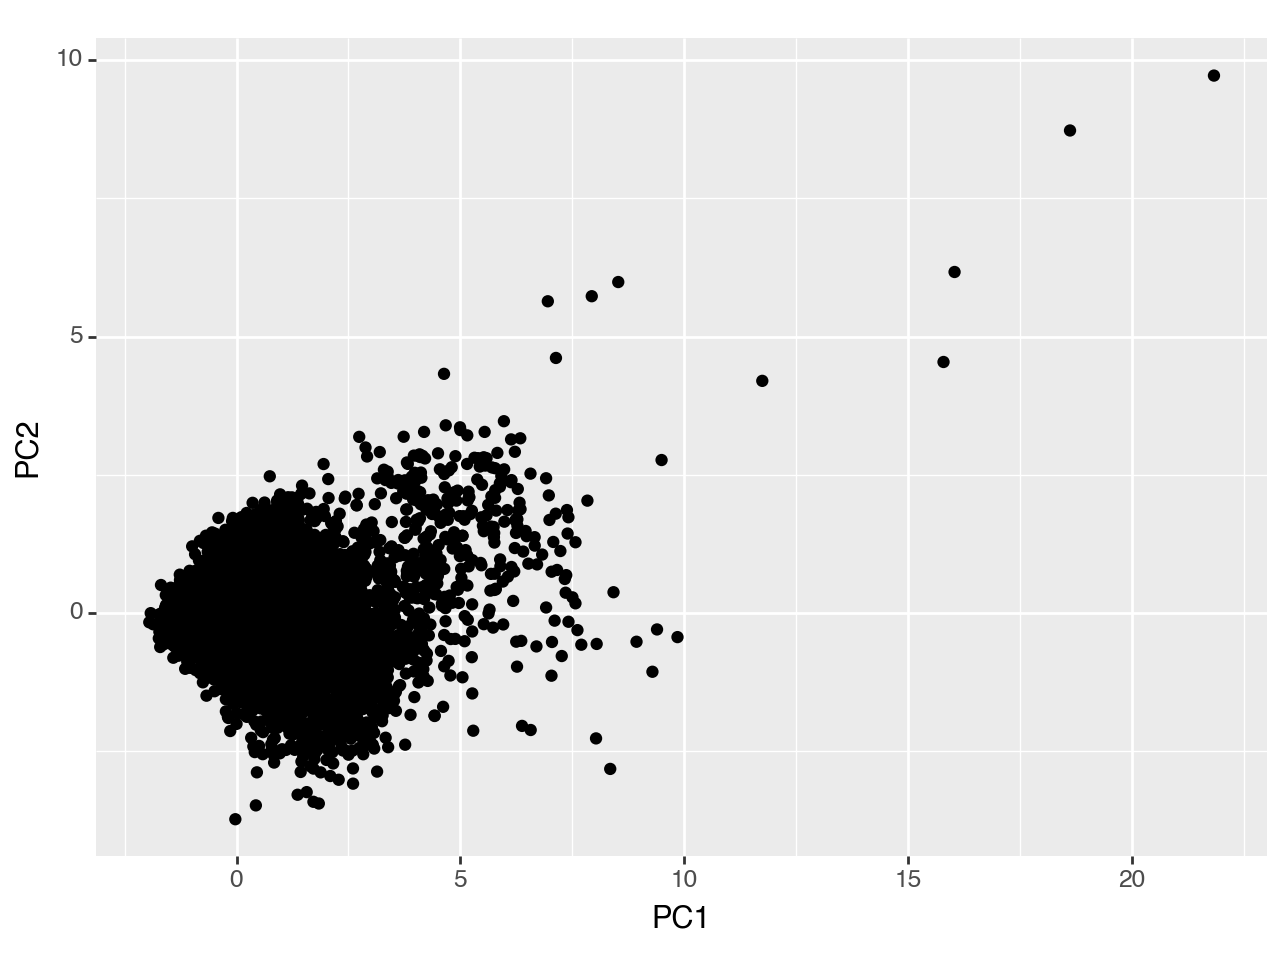

<Figure Size: (640 x 480)>

In [29]:
#the principle components
from sklearn.decomposition import PCA
pca = PCA(2)
pcs = pca.fit_transform(model.gene_emb.get_emb_table())
df_pcs = pd.DataFrame(data=pcs, columns=['PC1', 'PC2'])
plot = ggplot(df_pcs) + geom_point(aes("PC1", "PC2"))
plot